In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

## Data Load

In [2]:
train_16 = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'],dtype={"parcelid": int})

In [3]:
prop_16 = pd.read_csv('properties_2016.csv',dtype={"parcelid": int})

/home/hskimim/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_df1 = pd.merge(train_16,prop_16,on='parcelid', how ='left')

In [5]:
train_df = train_df1.copy()

train_17 = pd.read_csv('train_2017.csv',parse_dates=['transactiondate'],dtype={"parcelid": int})

prop_17 = pd.read_csv('properties_2017.csv',dtype={"parcelid": int})

train_df2 = pd.merge(train_17,prop_17,on='parcelid', how ='left',dtype={"parcelid": int})

train_df = pd.concat([train_df1,train_df2])

## Outer feature data analysis

- 'bathroomcnt'
- 'calculatedbathnbr'
- 'threequarterbathnbr'
- 'fullbathcnt'
- 'bedroomcnt'
- 'roomcnt’
- 'garagecarcnt'
- 'garagetotalsqft'

In [6]:
inner_feature= [
    '화장실 갯수',
    '화장실 갯수',
    '집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)',
    '풀옵션 화장실의 갯수',
    '침실 갯수',
    '주거지에있는 총 객실 수',
    '차고 갯수',
    '차고 평방(크기)'
]

In [7]:
inner_feature_col=[
    'basementsqft',
'finishedfloor1squarefeet',
'calculatedfinishedsquarefeet',
'finishedsquarefeet6',
'finishedsquarefeet12',
'finishedsquarefeet13',
'finishedsquarefeet15',
'finishedsquarefeet50'
]

In [12]:
inner_df = pd.DataFrame(columns=['name','feature'])
inner_df.name = inner_feature_col
inner_df.feature = inner_feature
inner_df

,name,feature
0,basementsqft,화장실 갯수
1,finishedfloor1squarefeet,화장실 갯수
2,calculatedfinishedsquarefeet,집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)
3,finishedsquarefeet6,풀옵션 화장실의 갯수
4,finishedsquarefeet12,침실 갯수
5,finishedsquarefeet13,주거지에있는 총 객실 수
6,finishedsquarefeet15,차고 갯수
7,finishedsquarefeet50,차고 평방(크기)


In [13]:
print(train_df[inner_feature_col].dtypes,end='\n\n'),
print('Number of outer_feature_col:  {}'.format(len(inner_feature_col)))

basementsqft                    float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet6             float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
dtype: object

Number of outer_feature_col:  8


### Individual columns' feature analysis

### Regression plot about numerical data

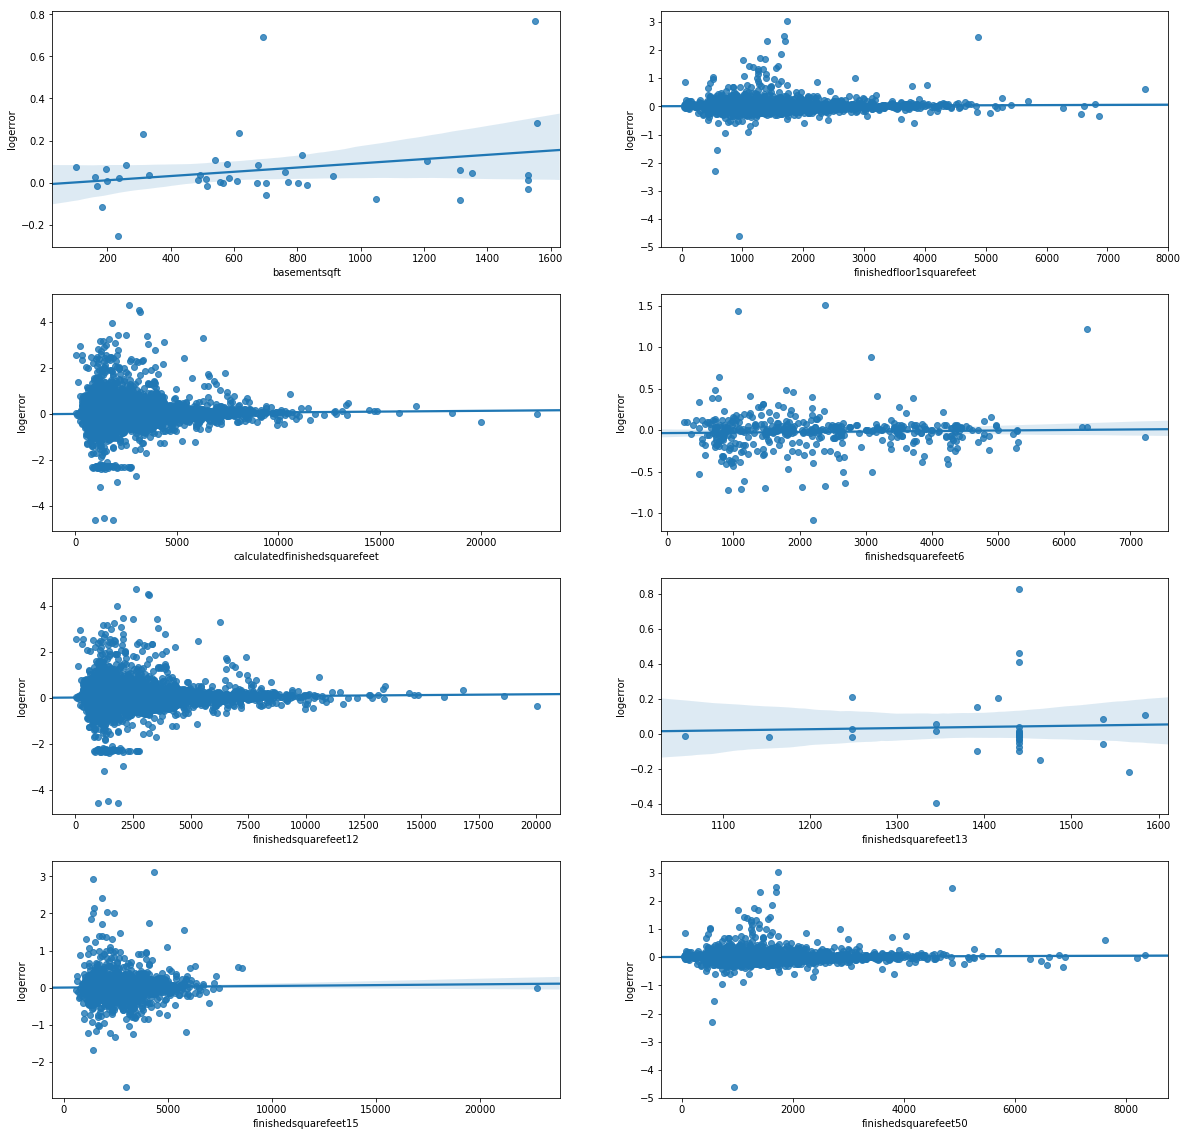

In [14]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(inner_feature_col):
    plt.subplot(4,2,idx+1)
    sns.regplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

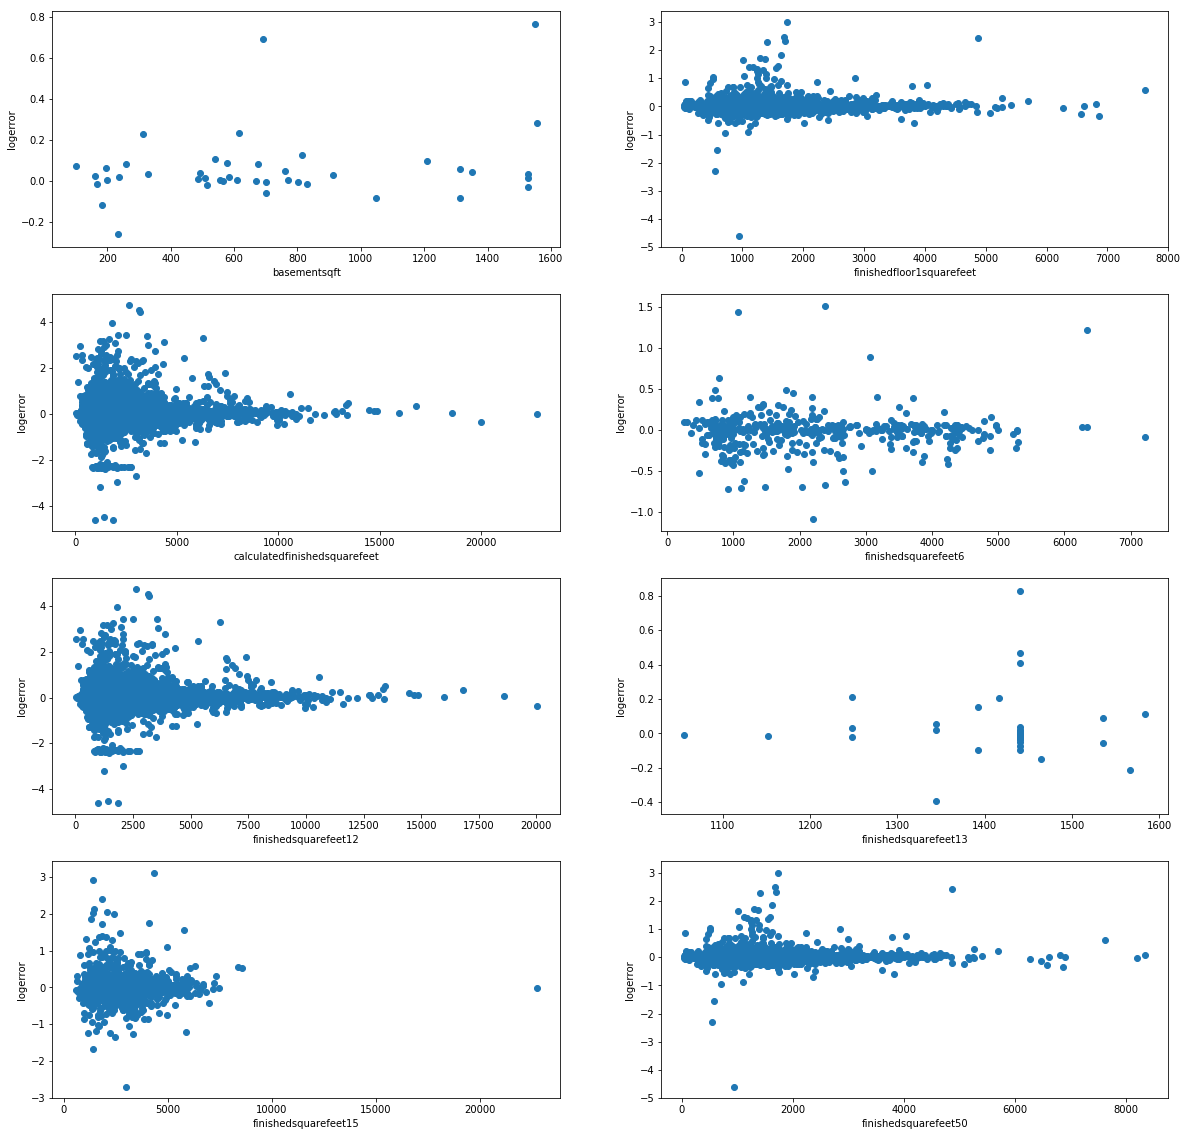

In [15]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(inner_feature_col):
    plt.subplot(4,2,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(inner_feature_col):
    plt.subplot(4,2,idx+1)
    sns.stripplot(train_df[col],train_df.logerror,data=train_df)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

## Comments